## import packages

In [1]:
# import packages
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import cv2

## Download dataset and Visualize

In [2]:
import torch.utils
import torch.utils.data


transform = transforms.ToTensor()

Train_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=True, download=False, transform=transform)
Test_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=False, download=False, transform=transform)

In [3]:
# Split Traindata and Validdata
from sklearn.model_selection import StratifiedShuffleSplit
train_labels = np.array(Train_dataset.targets)
test_labels = np.array(Test_dataset.targets)
# same proportion split dataset
# set split function
# if we need to do k cross validation, we should use StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)

# get split indices
indics = np.arange(len(train_labels))
train_indices, valid_indices = next(sss.split(indics, train_labels))

# Reset torch Dataset
train_dataset = torch.utils.data.Subset(Train_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(Train_dataset, valid_indices)

In [ ]:
# np.bincount: Count the number of occurrences of different integers
print(np.bincount(train_labels[train_indices]))

# Visualize the distribution of the data and the images

In [ ]:
# Visualize the distribution of train dataset
# The CIFAR-10 dataset consists of 
# 60000 32x32 colour images
# 10 classes, 
# 6000 images per class.

# Visualization
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Train class distribution
axes[0].bar(class_labels, np.bincount(train_labels[train_indices]))
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Valid class distribution
axes[1].bar(class_labels, np.bincount(train_labels[valid_indices]))
axes[1].set_title('Valid Set Class Distribution')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45)

# Test class distribution
axes[2].bar(class_labels, np.bincount(test_labels))
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Number of Samples')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# store images by class
Train_class_images = {i: [] for i in range(10)}
for img, label in train_dataset:
    Train_class_images[label].append(img)

# visualize 10 images per class
num_images = 10
fig, axes = plt.subplots(10, num_images, figsize=(15, 15))

# Set y axis labels
y_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    for j in range(num_images):
        # Restore image
        img = np.transpose((Train_class_images[i][j]*0.5 + 0.5).numpy(), (1, 2, 0))
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
    axes[i, 0].set_ylabel(y_labels[i], rotation=0, ha='right', va='center', fontsize=8)

plt.show()


### Process data

In [4]:
import cv2
from skimage.feature import hog

def extract_features(image_tensor, method):
    img_np = image_tensor.numpy().transpose(1, 2, 0)
    if method == 'sobel':
        # Transform to grayscale map
        # Sobel extract features
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edge_img = np.sqrt(sobel_x**2 + sobel_y**2)
        return edge_img.flatten()
    
    elif method == 'hog':
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        features = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=False, channel_axis=None)
        return features
    else:
        raise ValueError("Unsupported method: choose 'sobel' or 'hog'")


In [5]:
from sklearn.preprocessing import StandardScaler

def process_dataset(dataset, method=None):
    features = []
    labels = []

    # Extract feature from each image
    for img, label in dataset:
        if method:
            features_ex = extract_features(img, method=method)
            features.append(features_ex)
            labels.append(label)
        else:
            features.append(img.numpy().flatten())
            labels.append(label)
    # Transform to numpy
    X = np.array(features)
    y = np.array(labels)
    
    # Standard data
    if method == 'sobel' or method == None:
        scaler = StandardScaler()
        x_scaled = scaler.fit_transform(X)
        return x_scaled, y
    else:
        return X, y

In [16]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report
def plot_accuracy_and_confusion_matrix(y_true, y_pred, class_names, title, Method_name):
    report = classification_report(y_true, y_pred)
    
    print(f"{Method_name}")
    print(report)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

### Implement KNN

In [7]:
def Knn_classifier(train_images, train_labels, test_images, k=5):
    predictions=[]
    for test_image in test_images:
        # 1. Compute Euclidean distance
        distances = np.sqrt(np.sum((train_images - test_images) ** 2), axis=1)
        # 2. Get indices of k nearest images
        nearest_indices = np.argpartition(distances, k)[:k]
        # 3. Get k labels
        nearest_labels = train_labels[nearest_indices]
        # 4. Get majority voting labels
        majority_label = Counter(nearest_labels).most_common(1)[0][0]
        predictions.append(majority_label)
    return np.array(predictions)

def Knn_classifier_cdist(train_images, train_labels, test_images, k=5):
    # -preprocess data
    # numpy.array -> torch.tensor
    train_tensor = torch.tensor(train_images, dtype=torch.float32)
    test_tensor = torch.tensor(test_images, dtype=torch.float32)
    
    predictions=[]
    # 1. Compute Euclidean distance by torch.cdist
    distances = torch.cdist(test_tensor, train_tensor)
    # 2. Get indices of k nearest images
    nearest_indices = torch.topk(distances, k=k, largest=False, dim=1).indices
    # 3. Get k labels
    nearest_labels = train_labels[nearest_indices]
    # 4. Get majority voting labels
    for labels in nearest_labels:
        majority_label = Counter(labels).most_common(1)[0][0]
        predictions.append(majority_label)
    return np.array(predictions)

def Knn_classifier_cosine(train_images, train_labels, test_images, k=5):
    predictions = []
    # -preprocess data
    # numpy.array -> torch.tensor
    train_tensor = torch.tensor(train_images, dtype=torch.float32)
    test_tensor = torch.tensor(test_images, dtype=torch.float32)
    
    # 1. normalize images to use cosine distance
    train_images_norm = train_tensor / torch.norm(train_tensor, dim=1, keepdim=True)
    test_images_norm = test_tensor / torch.norm(test_tensor, dim=1, keepdim=True)
    
    # 2. Compute consine distance
    similarities = torch.mm(test_images_norm, train_images_norm.T)  
    
    # 3. Get indices of k nearest images
    nearest_indices = torch.topk(similarities, k=k, largest=True, dim=1).indices
    # 4. Get k labels
    nearest_labels = train_labels[nearest_indices]
    
    # 5. Get majority voting labels
    for labels in nearest_labels:
        majority_label = Counter(labels).most_common(1)[0][0]
        predictions.append(majority_label)
    
    return np.array(predictions)

In [8]:
# Select best K by Valid dataset
def select_k(train_imges, train_labels, valid_images, valid_labels, model):
    best_k = None
    best_accuracy = 0
    for k in [1, 5, 10, 15]:
        val_pred = model(train_imges, train_labels, valid_images,k)
        accuracy = np.mean(val_pred == valid_labels)
        print(f"k={k}, Val accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
    
    print(f"Best k is {best_k}, and its accuracy is {best_accuracy}")
    return best_k

In [9]:
# process dataset
# Without extract edge feature

X_train, y_train = process_dataset(train_dataset)
X_valid, y_valid = process_dataset(valid_dataset)
X_test, y_test = process_dataset(Test_dataset)

# Sobel
X_train_sobel, _ = process_dataset(train_dataset, 'sobel')
X_valid_sobel, _ = process_dataset(valid_dataset, 'sobel')
X_test_sobel, _ = process_dataset(Test_dataset, 'sobel')

# Hog
X_train_hog, _ = process_dataset(train_dataset, 'hog')
X_valid_hog, _ = process_dataset(valid_dataset, 'hog')
X_test_hog, _ = process_dataset(Test_dataset, 'hog')


k=1, Val accuracy: 0.3469
k=5, Val accuracy: 0.3524
k=10, Val accuracy: 0.3458
k=15, Val accuracy: 0.3405
Best k is 5, and its accuracy is 0.3524
Best k KNN without edge extract
              precision    recall  f1-score   support

           0       0.46      0.51      0.48      1000
           1       0.70      0.20      0.31      1000
           2       0.24      0.39      0.30      1000
           3       0.29      0.21      0.24      1000
           4       0.24      0.53      0.33      1000
           5       0.39      0.24      0.30      1000
           6       0.32      0.33      0.33      1000
           7       0.65      0.25      0.36      1000
           8       0.38      0.69      0.49      1000
           9       0.68      0.17      0.27      1000

    accuracy                           0.35     10000
   macro avg       0.44      0.35      0.34     10000
weighted avg       0.44      0.35      0.34     10000



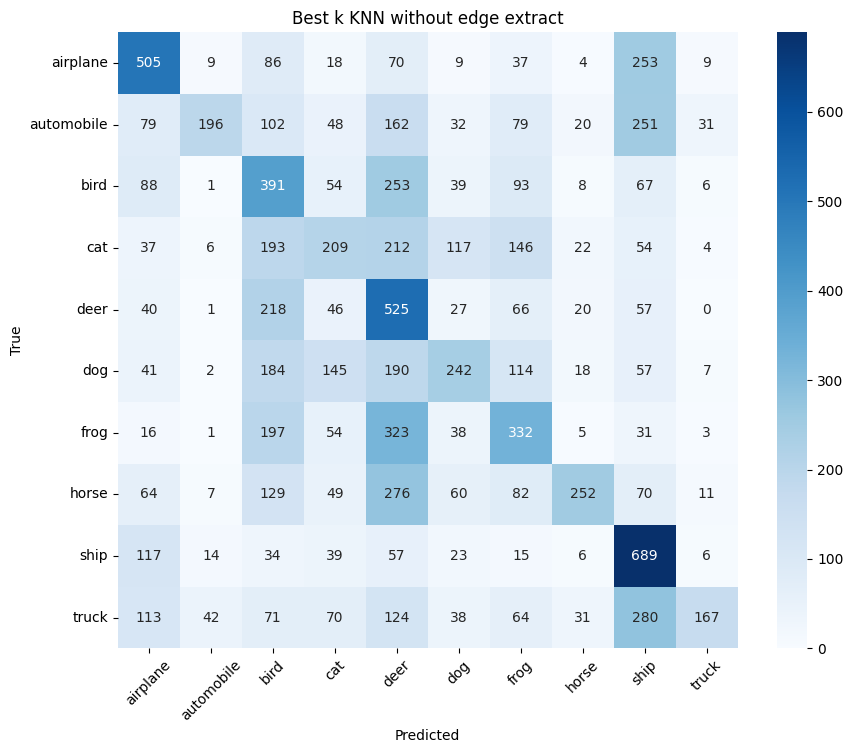

In [17]:
# Simple Cross validate

# Without extract edge feature
best_k = select_k(X_train, y_train, X_valid, y_valid, Knn_classifier_cdist)
pred_KNN = Knn_classifier_cdist(X_train, y_train, X_test, k=best_k)
plot_accuracy_and_confusion_matrix(y_test, pred_KNN, Train_dataset.classes, "Best k KNN without edge extract", "Best k KNN without edge extract")


k=1, Val accuracy: 0.3048
k=5, Val accuracy: 0.3181
k=10, Val accuracy: 0.3134
k=15, Val accuracy: 0.3055
Best k is 5, and its accuracy is 0.3181
Best k KNN with sobel edge extract
              precision    recall  f1-score   support

           0       0.55      0.31      0.40      1000
           1       0.56      0.24      0.34      1000
           2       0.32      0.28      0.30      1000
           3       0.22      0.13      0.17      1000
           4       0.20      0.59      0.30      1000
           5       0.31      0.19      0.24      1000
           6       0.24      0.52      0.33      1000
           7       0.54      0.24      0.33      1000
           8       0.41      0.43      0.42      1000
           9       0.51      0.16      0.24      1000

    accuracy                           0.31     10000
   macro avg       0.39      0.31      0.31     10000
weighted avg       0.39      0.31      0.31     10000



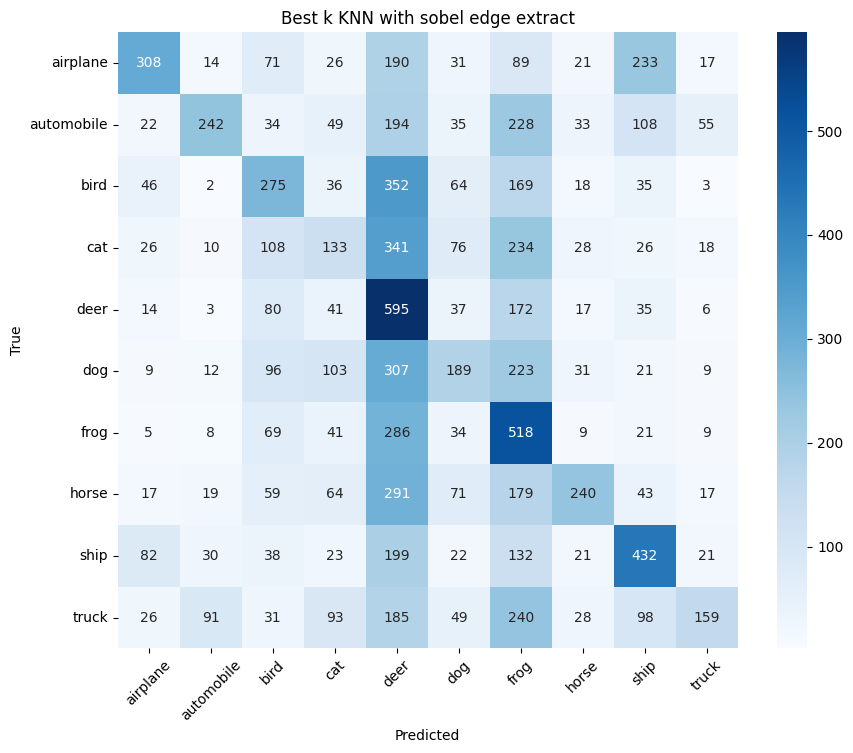

In [18]:
# # Sobel
best_k_sobel = select_k(X_train_sobel, y_train, X_valid_sobel, y_valid, Knn_classifier_cdist)
pred_KNN_sobel = Knn_classifier_cdist(X_train_sobel, y_train, X_test_sobel, k=best_k_sobel)
plot_accuracy_and_confusion_matrix(y_test, pred_KNN_sobel, Train_dataset.classes, "Best k KNN with sobel edge extract", "Best k KNN with sobel edge extract")

k=1, Val accuracy: 0.4509
k=5, Val accuracy: 0.4821
k=10, Val accuracy: 0.4928
k=15, Val accuracy: 0.4937
Best k is 15, and its accuracy is 0.4937
Best k KNN with hog edge extract
              precision    recall  f1-score   support

           0       0.77      0.45      0.57      1000
           1       0.70      0.67      0.69      1000
           2       0.59      0.26      0.36      1000
           3       0.50      0.10      0.17      1000
           4       0.29      0.63      0.39      1000
           5       0.49      0.29      0.36      1000
           6       0.32      0.84      0.46      1000
           7       0.71      0.44      0.54      1000
           8       0.64      0.60      0.62      1000
           9       0.66      0.58      0.62      1000

    accuracy                           0.49     10000
   macro avg       0.57      0.49      0.48     10000
weighted avg       0.57      0.49      0.48     10000



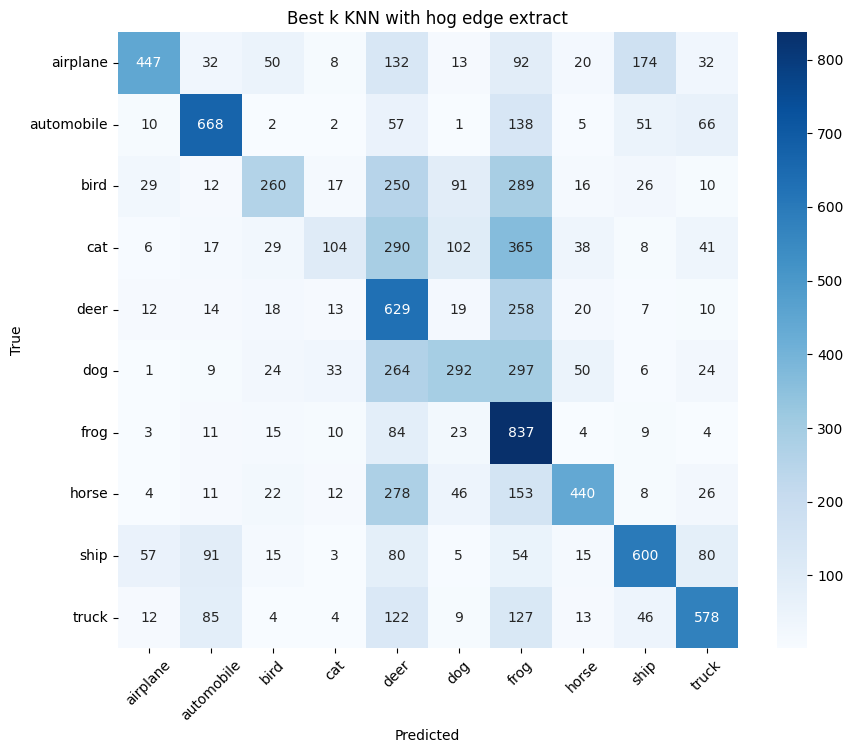

In [19]:
# Hog
best_k_hog = select_k(X_train_hog, y_train, X_valid_hog, y_valid, Knn_classifier_cdist)
pred_KNN_hog = Knn_classifier_cdist(X_train_hog, y_train, X_test_hog, k=best_k_hog)
plot_accuracy_and_confusion_matrix(y_test, pred_KNN_hog, Train_dataset.classes, "Best k KNN with hog edge extract", "Best k KNN with hog edge extract")

### Implement Linear Classifier

CIFAR10 dataset has 60,000 images\
one image has 3\*32\*32\*1B\
so all CIFAR10 dataset is 60,000\*3\*32\*32\*1B\
almost is 176MB

In [20]:
# Load Batch data
from torch.utils.data import DataLoader,TensorDataset

def generate_dataloder(Train_dataset, Test_dataset, method=None):
    X_train, y_train = process_dataset(Train_dataset,method)
    X_test, y_test = process_dataset(Test_dataset,method)

    train_images_tensor = torch.tensor(X_train, dtype=torch.float32)
    train_labels_tensor = torch.tensor(y_train, dtype=torch.long)
    test_images_tensor = torch.tensor(X_test, dtype=torch.float32)
    test_labels_tensor = torch.tensor(y_test, dtype=torch.long)
    
    batch_size = 1024
    train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, len(train_images_tensor[1])

In [21]:
# Y = WX + B
# Data process is same
# Now we implement linear classifier with nn.Linear.
# And we also implement loss function with nn.CrossEntropyLoss().

# Implement Linear classifier with nn.Linear
import torch.nn as nn
import torch.optim as optim

class LinearClassifier(nn.Module):
    def __init__(self, d_input, d_features):
        super().__init__()
        # This is a Fully Connect layer
        self.linear = nn.Linear(d_input, d_features)
        
    def forward(self, x):
        x = x.view(x.size(0),-1) # (batch_sisze, 3, 32 32) -> (bach_size, 3*32*32)
        return self.linear(x)

    
def train(model, num_epoch, train_loader):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epoch):
        model.train()
        batch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            output = model(images)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        if epoch % 5 == 0:
            print(f"epoch: {epoch}, loss:{batch_loss / len(train_loader)}")
            
def test(model, test_loader, edge_name=""):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            _, pred = torch.max(output.data, 1)
            correct += (pred == labels).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    plot_name = "LinearClassifier " + edge_name
    plot_accuracy_and_confusion_matrix(all_labels, all_preds, Train_dataset.classes, plot_name, plot_name)    
        


epoch: 0, loss:1.941927931746658
epoch: 5, loss:1.7413795407937498
epoch: 10, loss:1.7086797344441316
epoch: 15, loss:1.690798207205169
LinearClassifier 
              precision    recall  f1-score   support

           0       0.45      0.40      0.42      1000
           1       0.45      0.49      0.47      1000
           2       0.32      0.24      0.28      1000
           3       0.31      0.27      0.29      1000
           4       0.38      0.30      0.34      1000
           5       0.36      0.33      0.34      1000
           6       0.41      0.51      0.45      1000
           7       0.46      0.45      0.46      1000
           8       0.45      0.58      0.51      1000
           9       0.42      0.47      0.44      1000

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.40      0.41      0.40     10000



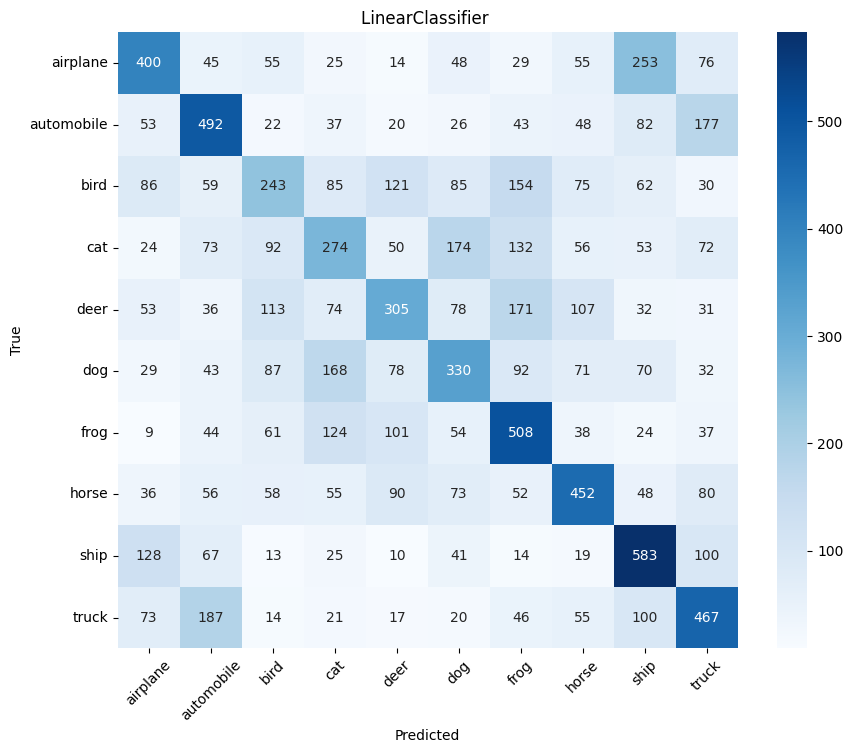

In [22]:
# Without edge extraction
train_loader, test_loader, d_input = generate_dataloder(Train_dataset, Test_dataset)
num_classes = 10
model_LC = LinearClassifier(d_input, num_classes)
train(model_LC, 20, train_loader)
test(model_LC, test_loader)


epoch: 0, loss:2.1537123650920633
epoch: 5, loss:1.905788068868676
epoch: 10, loss:1.8636148219205895
epoch: 15, loss:1.8426749341341915
LinearClassifier sobel
              precision    recall  f1-score   support

           0       0.38      0.45      0.41      1000
           1       0.36      0.40      0.38      1000
           2       0.32      0.39      0.35      1000
           3       0.26      0.15      0.19      1000
           4       0.32      0.29      0.30      1000
           5       0.29      0.26      0.27      1000
           6       0.34      0.34      0.34      1000
           7       0.31      0.27      0.29      1000
           8       0.38      0.47      0.42      1000
           9       0.32      0.31      0.31      1000

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.33     10000
weighted avg       0.33      0.33      0.33     10000



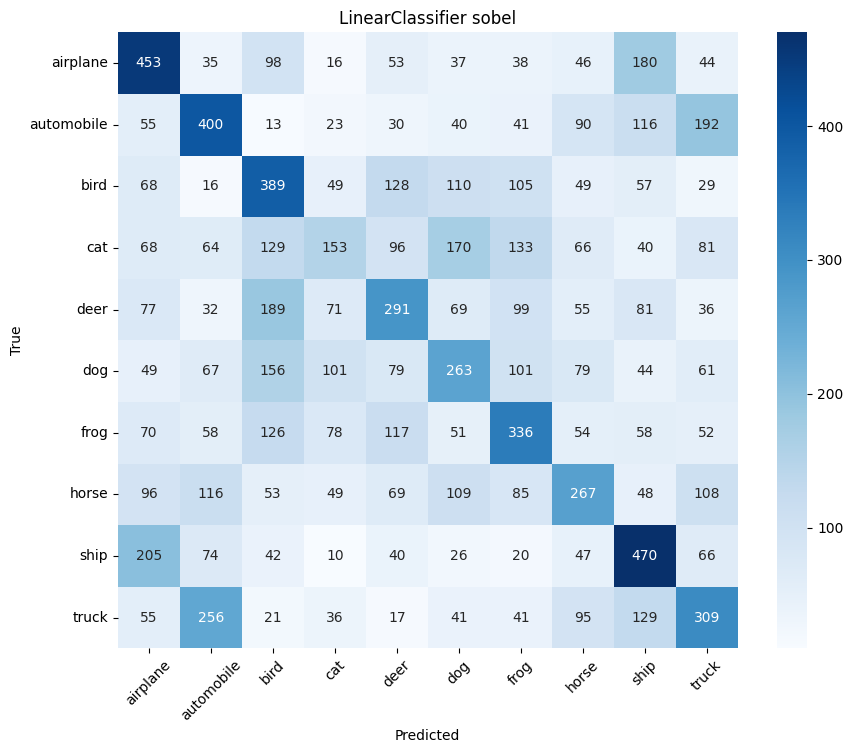

In [23]:
# Sobel
train_loader, test_loader, d_input = generate_dataloder(Train_dataset, Test_dataset, "sobel")
num_classes = 10
model_LC = LinearClassifier(d_input, num_classes)
train(model_LC, 20, train_loader)
test(model_LC, test_loader, "sobel")

epoch: 0, loss:2.2980369256467235
epoch: 5, loss:2.2570731980460033
epoch: 10, loss:2.2224488161048113
epoch: 15, loss:2.191139299042371
LinearClassifier hog
              precision    recall  f1-score   support

           0       0.43      0.31      0.36      1000
           1       0.39      0.49      0.43      1000
           2       0.39      0.11      0.17      1000
           3       0.19      0.12      0.14      1000
           4       0.27      0.25      0.26      1000
           5       0.28      0.55      0.37      1000
           6       0.32      0.46      0.38      1000
           7       0.46      0.24      0.32      1000
           8       0.35      0.55      0.43      1000
           9       0.49      0.34      0.40      1000

    accuracy                           0.34     10000
   macro avg       0.36      0.34      0.33     10000
weighted avg       0.36      0.34      0.33     10000



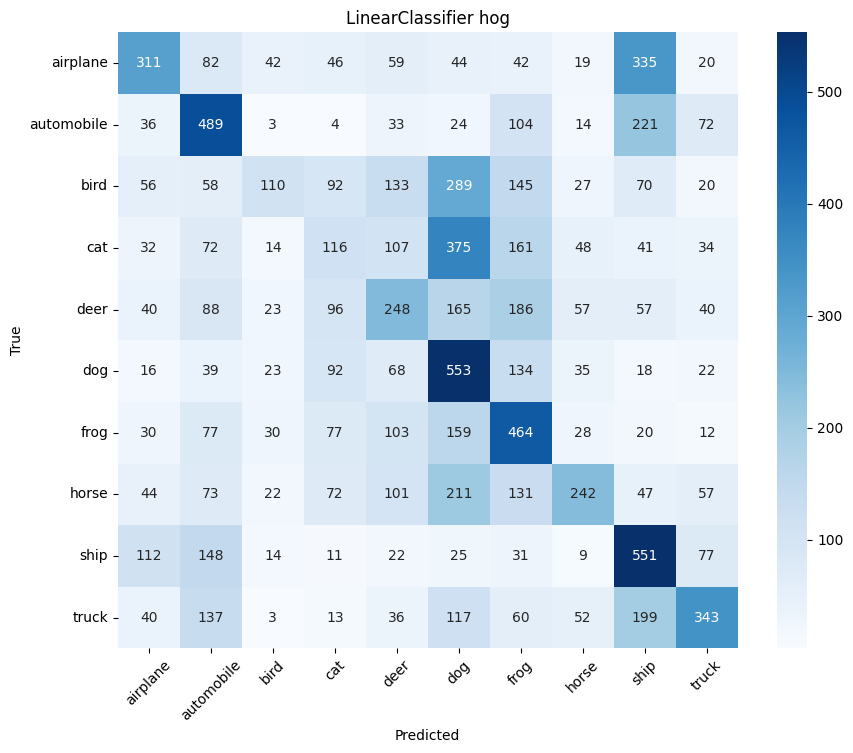

In [24]:
# Hog
train_loader, test_loader, d_input = generate_dataloder(Train_dataset, Test_dataset, 'hog')
num_classes = 10
model_LC = LinearClassifier(d_input, num_classes)
train(model_LC, 20, train_loader)
test(model_LC, test_loader, "hog")

### Implement SVM

In [25]:
from sklearn.svm import SVC

# Decrease training data to decrease training time
train_labels = np.array(Train_dataset.targets)
sample_size = 5000
sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)

indices = np.arange(len(train_labels))
train_indices_svm, _ = next(sss.split(indices, train_labels))
train_dataset_svm = torch.utils.data.Subset(Train_dataset, train_indices_svm)

# Split validation dataset
train_indices_svm_labels = np.array([Train_dataset.targets[i] for i in train_indices_svm])
valid_ratio = 0.2
new_sss = sss = StratifiedShuffleSplit(n_splits=1, train_size=valid_ratio, random_state=42)

new_indices = np.arange(len(train_indices_svm_labels))
train_indices_svm_new, valid_indices_svm = next(new_sss.split(new_indices, train_indices_svm_labels))

train_svm = torch.utils.data.Subset(train_dataset_svm, train_indices_svm_new)
valid_svm = torch.utils.data.Subset(train_dataset_svm, valid_indices_svm)

In [26]:
def Select_best_params(X_train_svm, y_train_svm, X_val_svm, y_val_svm):
    # Use validate dataset to choose best Kernel function
    # kernel function: linear, RBF, polynomial.
    kernel_candidates = [
        {'kernel': 'linear', 'C':1.0},
        {'kernel': 'rbf', 'C': 1.0},
        {'kernel': 'poly', 'C': 1.0, 'gamma': 'scale', 'degree': 3}
    ]

    # Choose best kernel function by validation 
    best_acc = 0
    best_kernel = None

    for params in kernel_candidates:
        model = SVC(**params)
        # train model in train_partial_scaled
        model.fit(X_train_svm, y_train_svm)
        
        # valid model in val_partial_scaled
        val_acc = model.score(X_val_svm, y_val_svm)
        print(f"Kernel: {params['kernel']}, Val_acc: {val_acc:.4f}")
        
        # compare acc
        if val_acc > best_acc:
            best_acc = val_acc
            best_kernel = params
            
    return best_kernel

In [27]:


def test_SVM(method="", best_kernel=None):
    if best_kernel is None:
        best_kernel={}
    if method == "":
        X_train_final, y_train_final = process_dataset(train_dataset_svm)
        X_test_svm, y_test_svm = process_dataset(Test_dataset)
    else:
        X_train_final, y_train_final = process_dataset(train_dataset_svm, method)
        X_test_svm, y_test_svm = process_dataset(Test_dataset, method)
    final_model = SVC(**best_kernel)
    print(f"\n Best Kernel: {best_kernel['kernel']}")
    print(f"Training train dataset svm...")
    final_model.fit(X_train_final, y_train_final)

    print(f"predict test dataset...")
    y_pred = final_model.predict(X_test_svm)
    plot_name = "SVM " + method
    plot_accuracy_and_confusion_matrix(y_test_svm, y_pred, Train_dataset.classes, plot_name, plot_name)

Kernel: linear, Val_acc: 0.2855
Kernel: rbf, Val_acc: 0.3605
Kernel: poly, Val_acc: 0.2452

 Best Kernel: rbf
Training train dataset svm...
predict test dataset...
SVM 
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      1000
           1       0.51      0.54      0.52      1000
           2       0.32      0.25      0.28      1000
           3       0.28      0.24      0.26      1000
           4       0.36      0.42      0.39      1000
           5       0.41      0.35      0.38      1000
           6       0.44      0.55      0.49      1000
           7       0.51      0.41      0.46      1000
           8       0.55      0.60      0.57      1000
           9       0.46      0.54      0.50      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.44     10000
weighted avg       0.44      0.44      0.44     10000



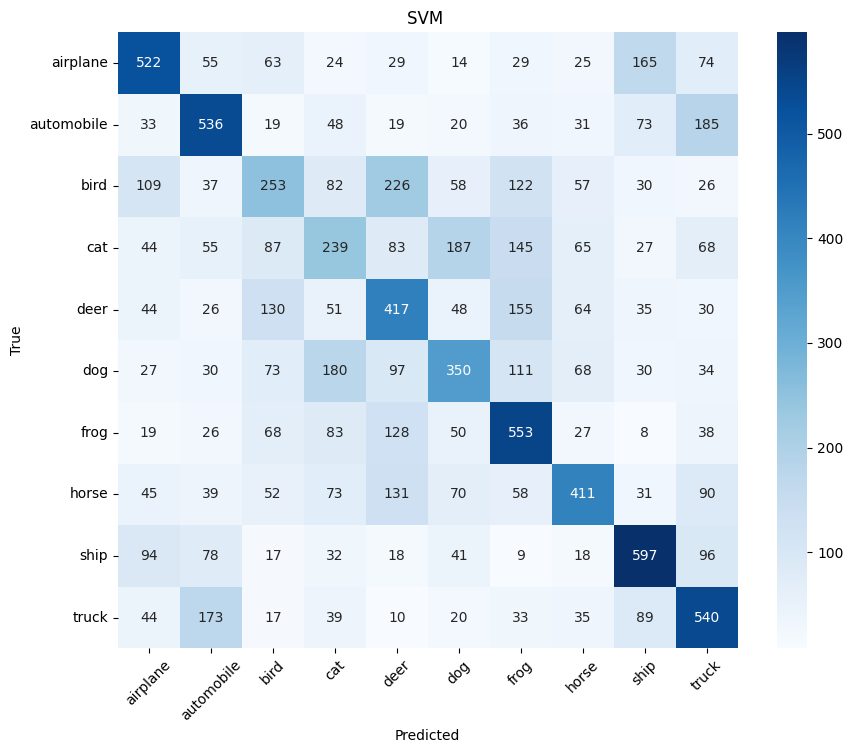

In [28]:
# Without edge extraction
X_train_svm, y_train_svm = process_dataset(train_svm)
X_val_svm, y_val_svm = process_dataset(valid_svm)
best_kernel = Select_best_params(X_train_svm, y_train_svm, X_val_svm, y_val_svm)
test_SVM(best_kernel=best_kernel)

Kernel: linear, Val_acc: 0.2442
Kernel: rbf, Val_acc: 0.2988
Kernel: poly, Val_acc: 0.1318

 Best Kernel: rbf
Training train dataset svm...
predict test dataset...
SVM sobel
              precision    recall  f1-score   support

           0       0.46      0.42      0.44      1000
           1       0.38      0.46      0.42      1000
           2       0.39      0.30      0.34      1000
           3       0.27      0.17      0.21      1000
           4       0.33      0.43      0.37      1000
           5       0.32      0.26      0.28      1000
           6       0.40      0.44      0.42      1000
           7       0.37      0.37      0.37      1000
           8       0.45      0.43      0.44      1000
           9       0.33      0.43      0.37      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.37     10000
weighted avg       0.37      0.37      0.37     10000



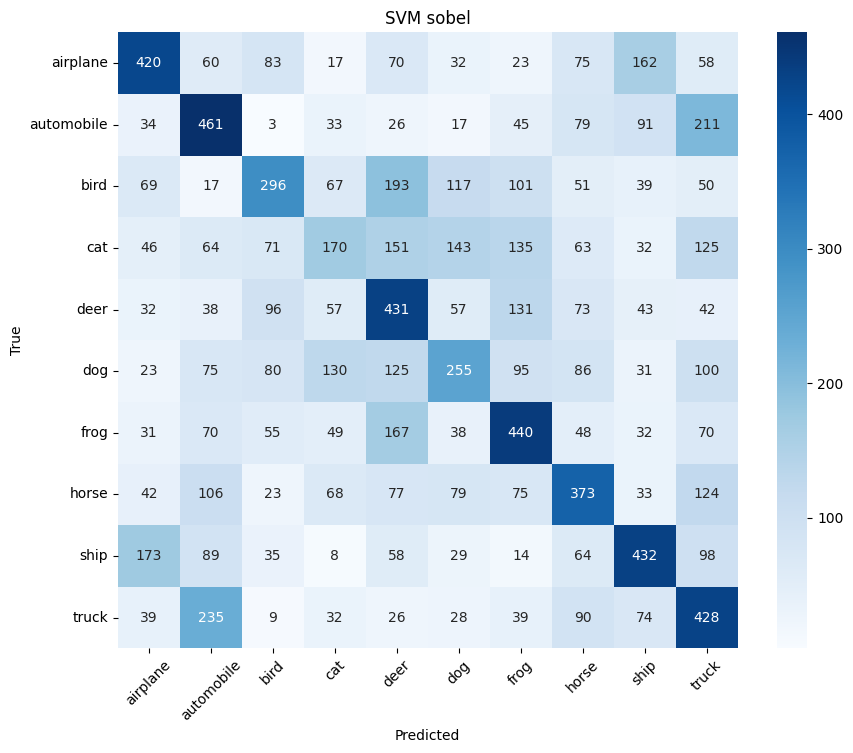

In [29]:
# Sobel
X_train_svm, y_train_svm = process_dataset(train_svm, 'sobel')
X_val_svm, y_val_svm = process_dataset(valid_svm, 'sobel')
best_kernel = Select_best_params(X_train_svm, y_train_svm, X_val_svm, y_val_svm)
test_SVM(method='sobel', best_kernel=best_kernel)

Kernel: linear, Val_acc: 0.4123
Kernel: rbf, Val_acc: 0.4647
Kernel: poly, Val_acc: 0.4250

 Best Kernel: rbf
Training train dataset svm...
predict test dataset...
SVM hog
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      1000
           1       0.63      0.66      0.65      1000
           2       0.46      0.40      0.42      1000
           3       0.35      0.33      0.34      1000
           4       0.44      0.51      0.47      1000
           5       0.45      0.43      0.44      1000
           6       0.56      0.64      0.60      1000
           7       0.63      0.57      0.60      1000
           8       0.62      0.62      0.62      1000
           9       0.64      0.63      0.63      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



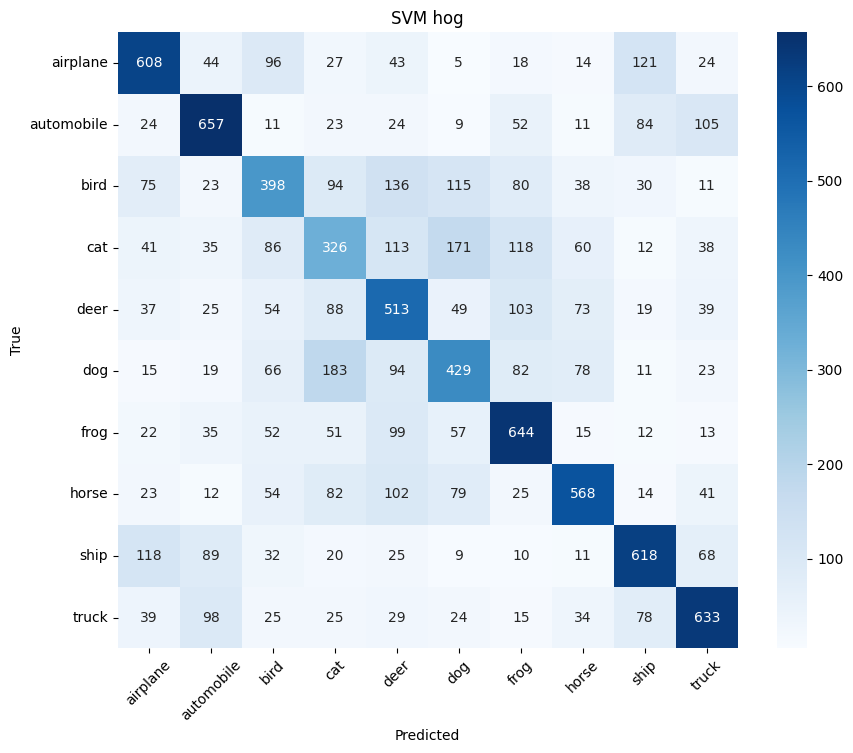

In [30]:
# Hog
X_train_svm, y_train_svm = process_dataset(train_svm, 'hog')
X_val_svm, y_val_svm = process_dataset(valid_svm, 'hog')
best_kernel = Select_best_params(X_train_svm, y_train_svm, X_val_svm, y_val_svm)
test_SVM(method='hog', best_kernel=best_kernel)

## Trying to Manul implemnt SVM

In [ ]:
from sklearn.decomposition import PCA

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: x.view(-1))
])

def dataset_to_numpy(dataset):
    data, labels = [], []
    for img, label in dataset:
        data.append(img.numpy())
        labels.append(label)
    return np.array(data), np.array(labels)

train_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=False, download=False, transform=transform)

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# PCA
# Use Principal component analysis to decrease data dimension
# In order to get less training time, we want to decrease data dimension (D) to decrease compute complexity O(N * D)
subset_size = 5000
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# core of SVM is decision edge and distance between the edge and nearest sample
# So our goal is to find decision edge
class SVM():
    def __init__(self, iters, lr, lambda_param):
        self.num_iters = iters
        self.learning_rate = lr
        self.lambda_p = lambda_param
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        n_samples, features = X.shape
        
        self.w = np.zeros(features)
        self.b = 0
        
        for _ in range(self.num_iters):
            # for _ in enumerate(X):
            #     # Judge outcome of classifying x
            #     # y*(wx-b) >= 1 is right else is falss
            #     outcome = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
            #     # Compute loss
            #     # loss = lambda*||x||^2 + labda*sum(max(0, 1-y_i*(wx_i-b)))
            #     # 1. right -> 1/Nsum(max(0, 1-y_i*(wx_i-b)))==0
            #     # 2. false -> 1/Nsum(max(0, 1-y_i*(wx_i-b)))==-y_ix_i
            #     if outcome:
            #         # Update Norm item ot increase distance between decision edge and sample.
            #         self.w -= self.learning_rate * (2 * self.lambda_p * self.w)
            #     else:
            #         # Update w and b to find currect decision edge
            #         self.w -= self.learning_rate * (2 * self.lambda_p * self.w - np.dot(x_i, y[idx]))
            #         self.b -= self.learning_rate * self.lambda_p * y[idx]
            
            # Using matrix parallel computing gradient
            margins = y * (np.dot(X, self.w) - self.b)
            violations = margins < 1
            
            grad_w = (2 * self.lambda_p * self.w) - (X[violations] * y[violations, np.newaxis]).sum(axis=0) / n_samples
            grad_b = -y[violations].mean()
            
            self.w -= self.learning_rate * grad_w
            self.b -= self.learning_rate * grad_b
    
    def predict(self, X):
        linear_out = np.dot(X, self.w) - self.b
        return np.sign(linear_out)
    
# One-vs-Rest
# Use 10 SVM classifiers to classity 10 classes 
# finally we choose the highest predict score to be predicted class
class MultiClassSVM():
    def __init__(self, iters=1000, lr=0.01, lambda_param=0.1):
        self.num_iters = iters
        self.lr = lr
        self.lambda_p = lambda_param
        self.classifiers = []
        
    def fit(self, X, y):
        self.classes = np.unique(y)
        # Training 10 svm classifiers
        for i, cls in enumerate(self.classes):
            print(f"Training {i}_th svm")
            y_binary = np.where(y == cls, 1, -1)
            svm = SVM(self.num_iters, self.lr, self.lambda_p)
            svm.fit(X, y_binary)
            self.classifiers.append(svm)
            print(f"Trained {i}_th svm")
    
    def predict(self, X):
        scores = np.array([svm.predict(X) for svm in self.classifiers])
        return self.classes[np.argmax(scores, axis=0)]
        

In [ ]:
multiclass_svm = MultiClassSVM()
multiclass_svm.fit(X_train_pca, y_train)
y_pred = multiclass_svm.predict(X_test_pca)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")